In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('tagsets')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/marco/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/marco/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package tagsets to /home/marco/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/marco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Get the data + EDA with nltk

In [2]:
from llm.config import DATA_DIR, IMAGES_DIR
filepath = DATA_DIR.joinpath('amazon_reviews.csv')

df = pd.read_csv(filepath, nrows=100)
print(df.shape)

(100, 11)


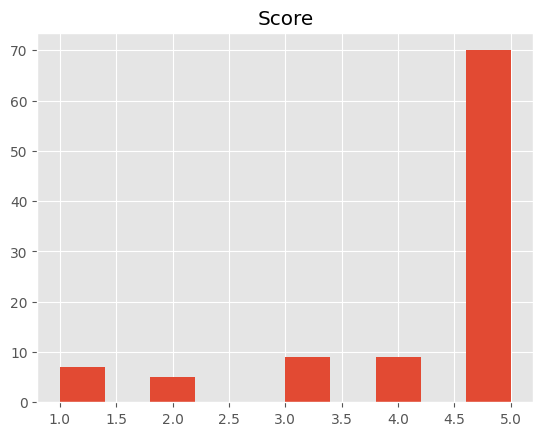

In [3]:
df[['Score']].hist()
plt.savefig(IMAGES_DIR.joinpath('score.jpeg'))

In [4]:
min_len = 100
for i, row in df.iterrows():

    new_len = len(row['Text'].split())
    if new_len < min_len:
        min_len = new_len

        print(i, new_len)
example = df['Text'][43]
example

0 48
2 21
10 17
15 16
43 14


'Great mustard! Place in a ramekin next to cheeses and meats.  Works with anything!'

In [5]:
# Tokenize the text

tokens = nltk.word_tokenize(example)
tokens[:10]

['Great',
 'mustard',
 '!',
 'Place',
 'in',
 'a',
 'ramekin',
 'next',
 'to',
 'cheeses']

In [6]:
# Part of Speech tagger

tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Great', 'NNP'),
 ('mustard', 'NN'),
 ('!', '.'),
 ('Place', 'NN'),
 ('in', 'IN'),
 ('a', 'DT'),
 ('ramekin', 'JJ'),
 ('next', 'JJ'),
 ('to', 'TO'),
 ('cheeses', 'NNS')]

In [7]:
## Complete list of tags
# nltk.help.upenn_tagset()

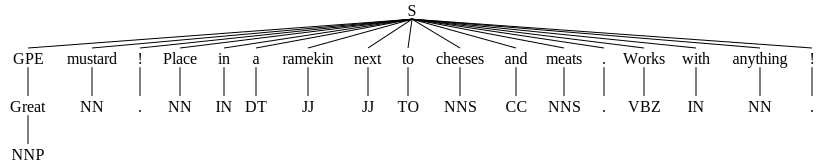

In [8]:
# Groups tokens into chunk of text
entities = nltk.chunk.ne_chunk(tagged)

# Need Tkinter
entities.draw()
entities

In [9]:
nltk.help.upenn_tagset('DT')

DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those


# VADER sentiment scoring

VADER (Valence Aware Dictionary and sEntiment Reasoner ) is a lexicon and rule-based sentiment analysis tool designed specifically for social media and other online texts. It evaluates the sentiment of words and phrases within context, applying grammatical rules and a sentiment lexicon.

**Pros**
- High Sensitivity to Context: Effectively interprets context like capitalization, intensifiers, and emoticons.
- Specific to Social Media: Optimized for the nuances of social media text, including slang and unconventional language.
- Fast and Efficient: Suitable for real-time processing due to its straightforward computational model.

**Cons**
- Limited to Lexicon: Relies on a predefined list of words, which may miss sentiments expressed through novel slang or expressions.
- Less Effective Outside Social Media: May not perform as well with formal texts or content significantly different from typical social media discourse.
- Language Dependency: Primarily developed for English, with its effectiveness reduced in other languages.

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

# Examples of polarity scores

In [11]:
# Very positive

sia.polarity_scores('I am the happiest person ever')

{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}

In [12]:
# Very negative 

sia.polarity_scores('This is the worst day of my life')

{'neg': 0.369, 'neu': 0.631, 'pos': 0.0, 'compound': -0.6249}

In [13]:
# polarity of example comment 

sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.719, 'pos': 0.281, 'compound': 0.6892}

In [14]:
# Run the polarity score on the entire dataset

results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
# Reshape results dict into pandas DF and merge with data DF

vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

### Plot VADER results

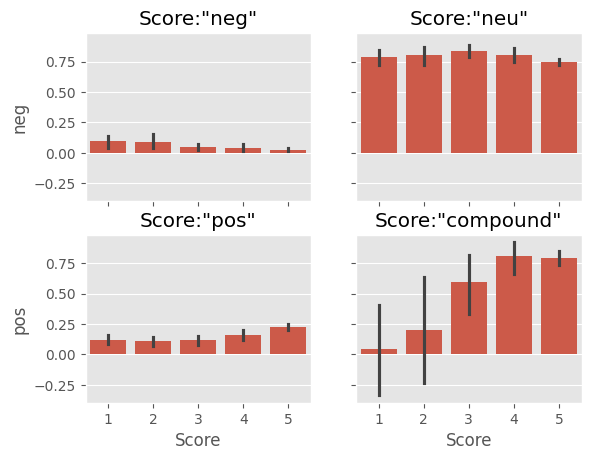

In [16]:
# Plot the compound score
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for (count, score) in enumerate(['neg', 'neu', 'pos', 'compound']):
    cc, rr = count //2, count % 2
    sns.barplot(data=vaders, x='Score', y=score, ax=ax[cc,rr])
    ax[cc, rr].set_title(f'Score:"{score}"')

plt.savefig(IMAGES_DIR.joinpath('vader_scores.jpeg'))

# Roberta Pretrained Model

**BERT** (Bidirectional Encoder Representations from Transformers) is a model developed by Google, using the Transformer architecture, particularly the attention mechanism, to process words in relation to all other words in a sentence, rather than one-by-one sequentially. 

**RoBERTa** (Robustly Optimized BERT Approach) builds upon BERT with several key improvements and optimizations that boost performance on a wide array of natural language processing tasks.

I will use a pretrained model (cardiffnlp/twitter-roberta-base-sentiment)


In [17]:
from llm.core.amazon import polarity_scores_roberta
from llm.core.amazon import polarity_scores_vader

In [18]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/home/marco/Desktop/ATOM/LLM/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# roberta_results 
polarity_scores_roberta(example, tokenizer, model)

{'roberta_neg': 0.0027597933,
 'roberta_neu': 0.06887546,
 'roberta_pos': 0.9283647}

In [20]:
# vader_results 
polarity_scores_vader(example)

{'vader_neg': 0.0,
 'vader_neu': 0.719,
 'vader_pos': 0.281,
 'vader_compound': 0.6892}

In [21]:
# Calculate both results for the whole dataframe 

results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_results = polarity_scores_vader(text)
        roberta_result = polarity_scores_roberta(text, tokenizer, model)
        results[myid] = {**vader_results, **roberta_result}
    except:
        print(i, myid, 'excluding since too big')

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

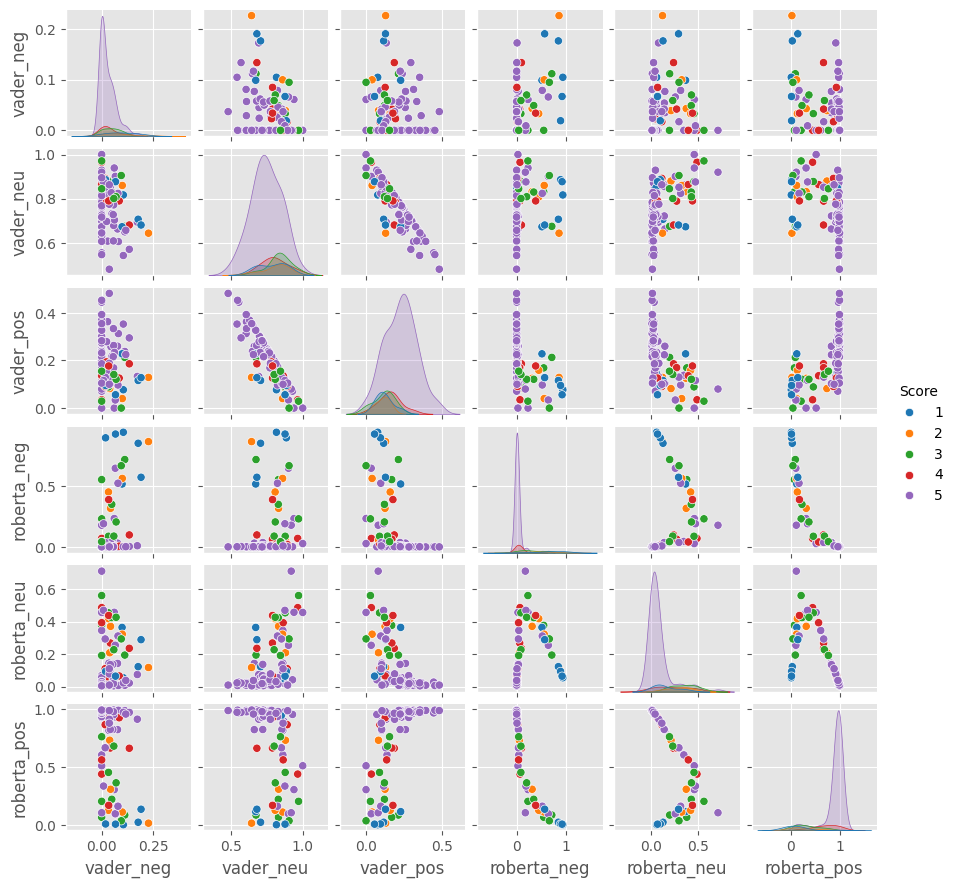

In [53]:
sns.pairplot(
    data=results_df,
    vars=['vader_neg', 'vader_neu', 'vader_pos',
          'roberta_neg', 'roberta_neu', 'roberta_pos'],
    hue='Score',
    palette='tab10', 
    height=1.5
    ).savefig(IMAGES_DIR.joinpath('vader_vs_roberta.jpeg'))

# Review Predictions

Let's have a look at false positive and false negatives for the two models:
- False positives: negative reviews that are predicted to be positive
- False negatives: positive reviews that are predicted as negative

In [24]:
# False positive Roberta
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'This product is outstanding in quality, however it is a third of this price at my local supermarket, in fact it is for $3.49!  Convenience does have a price!'

In [25]:
# False positive VADER
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'Although a rubbery toy might be fine for a dog, I prefer to enjoy meaty items. This was poor and almost got thrown to the canines. Oh, well.'

In [26]:
# False negative Roberta
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'I\'ve never written a product review before.<br />I come from a Jewish family that always made chicken soup from scratch. There was nothing like it.<br />Store bought soups always tasted like they were "manufactured" with funky ingredients. Chicken consumme was the worst.<br />However, I just discovered Manischewitz condensed chicken soup and it is the real deal. It\'s definately more expensive, but it\'s worth it!...and their matzo balls seal the deal.'

In [27]:
# False negative VADER
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

"I like this soup a lot. It's not as good as real gumbo, but it is good for a canned soup. The cost per can is less than what you'd pay at a super stop & shop, so if you eat it often, get it here than there."

In [28]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Unnamed: 0', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Correlation Matrix

Another way to represent the accuracy of our model is to calcuate the correlation matrix and print it as a heat map.

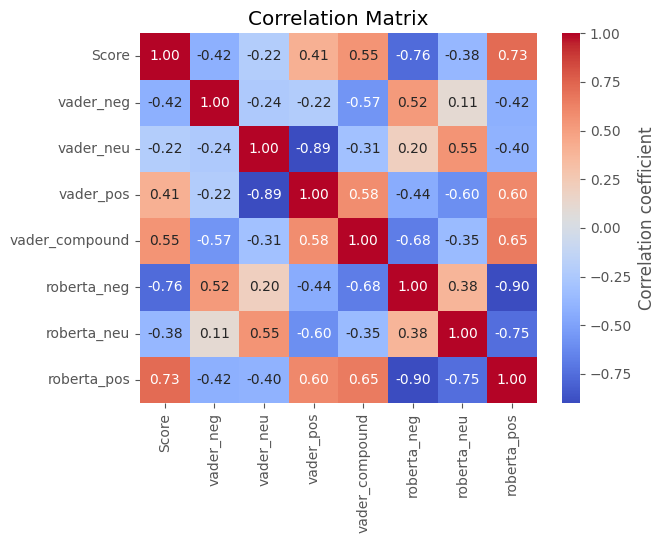

In [29]:
corr_matrix = results_df[[
    'Score',
    'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'roberta_neg', 'roberta_neu', 'roberta_pos'
]].corr()

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    cbar_kws={'label': 'Correlation coefficient'})

# Add titles and labels
plt.title('Correlation Matrix')
plt.savefig(IMAGES_DIR.joinpath('correlation_matrix.jpeg'))

# Confusion Matrix

A confusion matrix can tell us how many scores are predicted correctly. To do so, we first need to map the results from our models into integers. 

In [30]:
from llm.core.amazon import map_scores

results_df['vader_int'] = results_df.apply(lambda row: map_scores(row, 'vader'), axis=1)
results_df['roberta_int'] = results_df.apply(lambda row: map_scores(row, 'roberta'), axis=1)

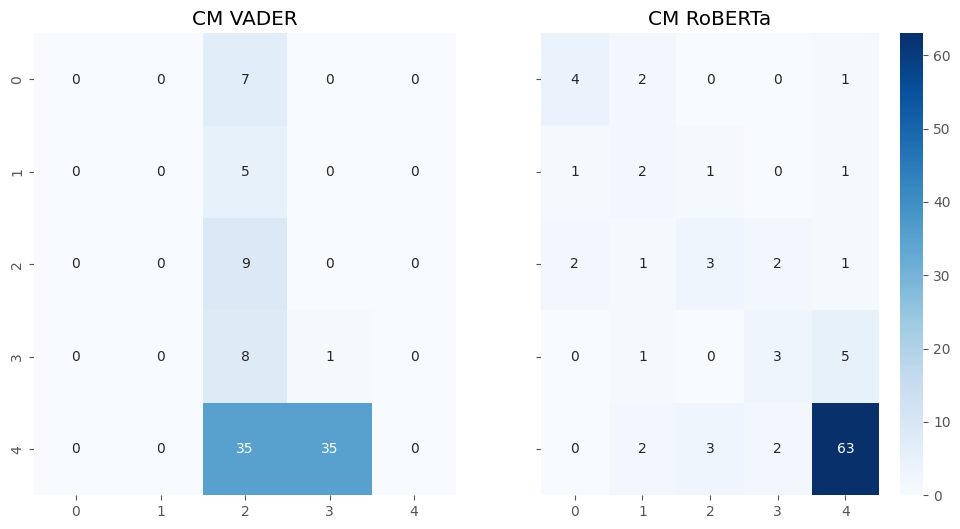

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is defined elsewhere and contains the necessary columns
cm1 = confusion_matrix(results_df['Score'], results_df['vader_int'])
cm2 = confusion_matrix(results_df['Score'], results_df['roberta_int'])

# Calculate the maximum value from both confusion matrices for consistent color scaling
vmax = np.max([cm1.max(), cm2.max()])

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Create heatmaps
sns.heatmap(cm1, annot=True, fmt="d", cmap='Blues', ax=ax[0], cbar=False, vmax=vmax)
sns.heatmap(cm2, annot=True, fmt="d", cmap='Blues', ax=ax[1], vmax=vmax)


# Add titles and labels
ax[0].set_title('CM VADER')
ax[1].set_title('CM RoBERTa')
plt.savefig(IMAGES_DIR.joinpath('confusion_matrix.jpeg'))

# Transformers Pipeline

Quick & easy way to run sentiment predictions

In [32]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/marco/Desktop/ATOM/LLM/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [33]:
sent_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9415168166160583}]